<a href="https://colab.research.google.com/github/ebrahimpichka/conv-autoencoder/blob/main/Auto_Encoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convoluntional Auto-Encoders implementation using Pytorch



the auto-encoder is trained and tested on FashionMNIST dataset

the overall schema of the model is shown below:
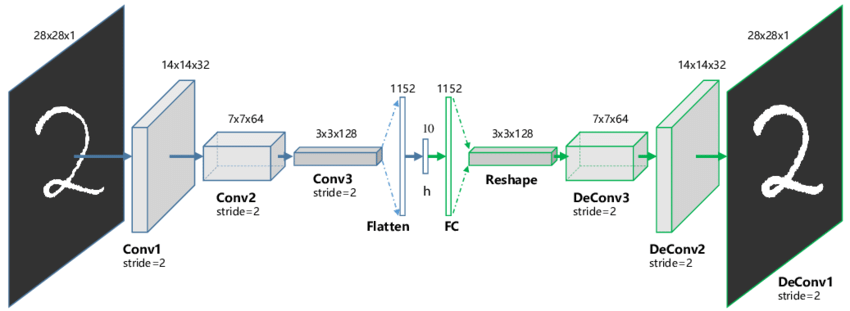

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
import torch

## Preparing dataset and creating train and test dataloaders

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [57]:
# creating data loaders

BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=0)

## Defining Convolutional Autoencoder Model

creating Encoder and Decoder Classes

In [29]:
# Creating Encoder Class
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # convoloution encoder block: 1x28x28 >>> 32x5x5
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1,), # in: 1x28x28 -> out: 16x26x26
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2,stride=2),                               # in: 16x26x26 -> out: 16x13x13
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),# in: 16x13x13 -> out: 32x11x11
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2),                                        # in: 32x11x11 -> out: 32x5x5    ---------> 800 params
        )

        # flatten: 32x5x5 >>> 1x800
        self.flattener = nn.Flatten()

        # linear encoder block: 1x800 >>> 1x32
        self.linear = nn.Sequential(
            nn.Linear(in_features=800,out_features=128),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=128,out_features=32),
            nn.LeakyReLU(0.1)
        )
    
    def forward(self, x):
        x = self.conv_block(x)
        x = self.flattener(x)
        x = self.linear(x)
        return(x)


In [30]:
# Creating Decoder Class
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # linear decoder block: 1x32 >>> 1x800
        self.linear = nn.Sequential(
            nn.Linear(in_features=32,out_features=128),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=128,out_features=800),
            nn.LeakyReLU(0.1)
        )
        
        # transpose convoloution(deconvoloution) decoder block: 32x5x5 >>> 1x28x28
        self.deconv_block = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=3,padding=1),    # in: 32x5x5 -> out: 16x13x13
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2),               # in: 16x13x13 -> out: 1x28x28 
            nn.Sigmoid()                
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(-1,32,5,5)
        x = self.deconv_block(x)
        return(x)

## getting cuda device, creating model objects, and movig model objects to device

In [37]:
# defining encoder and decoder blocks
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print("Current device:",device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

Current device: cuda:0


## Setting the Cost function (Binary Cross-entropy) and Optimizer (Adam)

In [38]:
# Cost Function: Binary Cross Entropy
criterion = nn.BCELoss()

# on how to use two different set of params: https://discuss.pytorch.org/t/how-to-optimize-multi-models-parameter-in-one-optimizer/3603/10
#                                            https://discuss.pytorch.org/t/optimizer-on-multi-neural-networks/20572
# Adam Optimizer
params = list(encoder.parameters()) + list(decoder.parameters())
opt = torch.optim.Adam(params,lr=0.001)

## Training Autoencoder

In [ ]:
#Epochs
EPOCHS = 200
loss_history = []
for epoch in range(1, EPOCHS+1):
    train_loss = 0.0

    #Training
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        opt.zero_grad()
        encoded = encoder(images)
        outputs = decoder(encoded)
        loss = criterion(outputs, images)
        loss.backward()
        opt.step()
        train_loss += loss.item()*images.size(0)/BATCH_SIZE
          
    train_loss = train_loss/len(train_loader)
    loss_history.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

## Evaluation

Text(0, 0.5, 'loss')

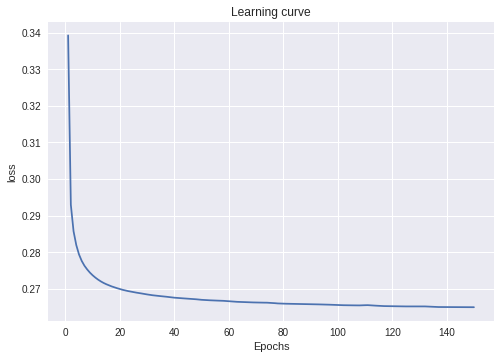

In [40]:
plt.style.use("seaborn")
plt.plot(list(range(1,EPOCHS+1)), loss_history, label="train loss")
plt.title("Learning curve")
plt.xlabel("Epochs")
plt.ylabel("loss")

Original Images:



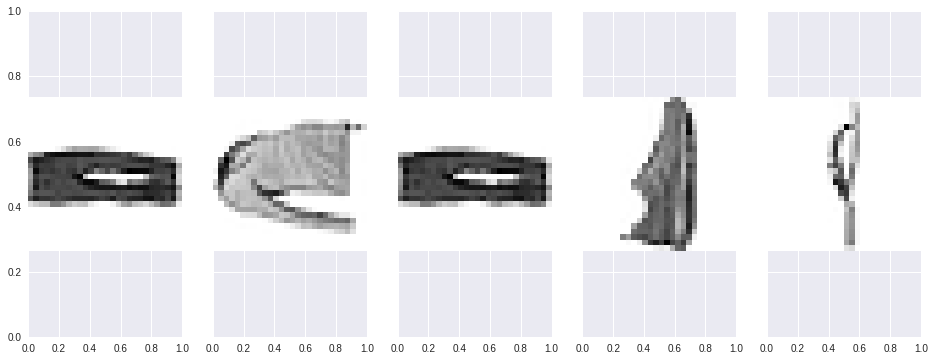

Reconstructed Images:



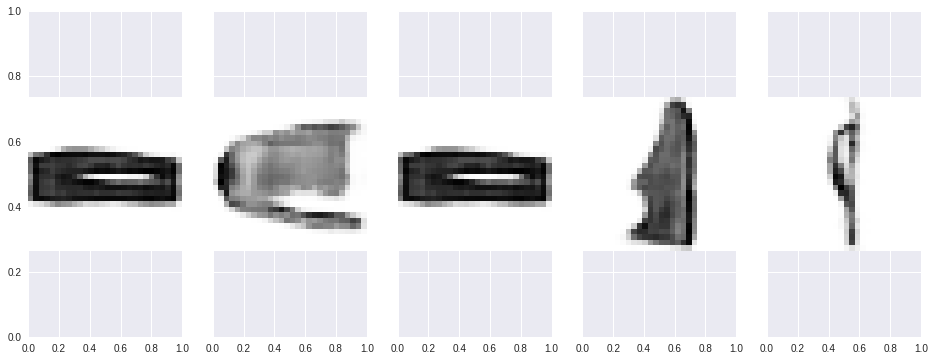

In [59]:
def plot_image(img): 
    plt.imshow(np.transpose(img.reshape(28,28)))

#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

encoder.eval()
decoder.eval()

#Sample outputs
images = images.to(device)
encoded = encoder(images)
output = decoder(encoded)
images = images.cpu().numpy()

output = output.detach().cpu().numpy()

# Original Images
print("Original Images:\n")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(16,6))

to_show_indx = np.random.randint(low=0, high=63, size=5)
for plot_inx, image_idx in enumerate(to_show_indx):
    ax = fig.add_subplot(1, 5, plot_inx+1, xticks=[], yticks=[])
    plot_image(images[image_idx])
plt.show()

# Reconstructed Images
print('Reconstructed Images:\n')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(16,6))
for plot_inx, image_idx in enumerate(to_show_indx):
    ax = fig.add_subplot(1, 5, plot_inx+1, xticks=[], yticks=[])
    plot_image(output[image_idx])
plt.show()

# Applications:

<li> Dimentinality Reduction
<li> Denoising noisy images

In [60]:
# Dimentinality Reduction
images, labels = dataiter.next()
images = images.to(device)
encoded = encoder(images)
output = decoder(encoded)
images = images.cpu().numpy()

print("Image size:",images.shape[1:],">>>",28*28)
print("Encoded image size reduced to:",encoded.shape[1])

Image size: (1, 28, 28) >>> 784
Encoded image size reduced to: 32


### Denoising noisy images

Noisy Images:



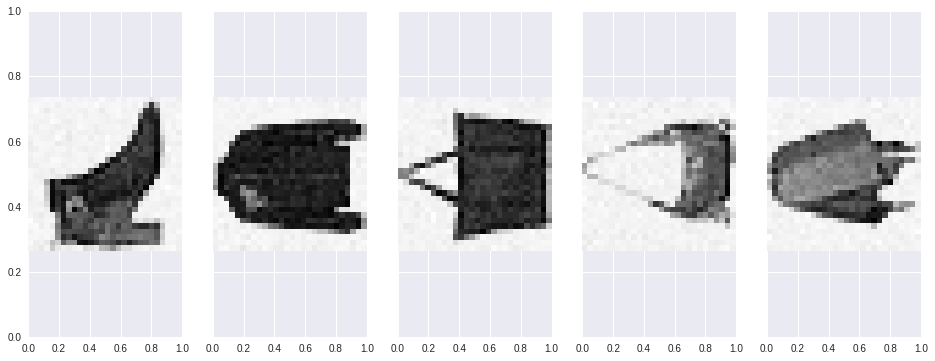


Denoised Images:



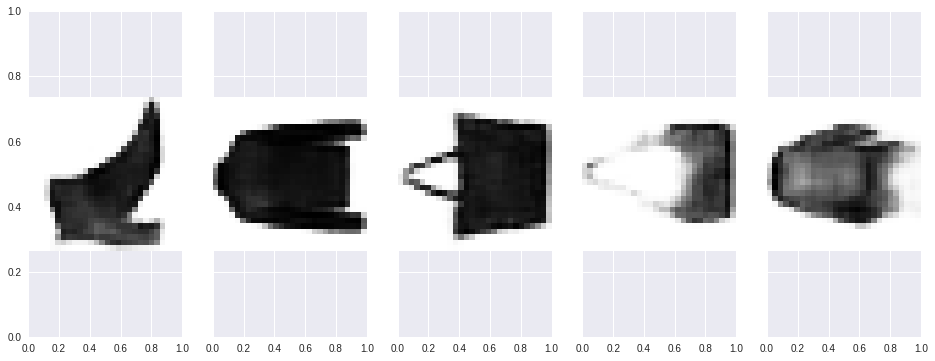

In [63]:
# Denoising noisy images

#Batch of test images
images, labels = dataiter.next()

#creating noisy image
nosie = torch.randn_like(images).to(device)
images = images.to(device)
noisy_images = images + nosie/30

encoded = encoder(noisy_images)
output = decoder(encoded)

noisy_images = noisy_images.cpu().numpy()
output = output.detach().cpu().numpy()

# Original Images
print("Noisy Images:\n")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(16,6))

to_show_indx = np.random.randint(low=0, high=63, size=5)
for plot_inx, image_idx in enumerate(to_show_indx):
    ax = fig.add_subplot(1, 5, plot_inx+1, xticks=[], yticks=[])
    plot_image(noisy_images[image_idx])
plt.show()

# Reconstructed Images
print('\nDenoised Images:\n')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(16,6))
for plot_inx, image_idx in enumerate(to_show_indx):
    ax = fig.add_subplot(1, 5, plot_inx+1, xticks=[], yticks=[])
    plot_image(output[image_idx])
plt.show()